# Part 2: Building an Interactive Agent with a Human Feedback Loop

Welcome to the advanced version of our Podcast Script Brewer! This notebook builds on the concepts from `01_foundational_script_agent.ipynb`, transforming our simple generator into a truly interactive AI partner that can improve its work based on feedback.

### The Challenge: From a Simple Generator to a Persistent Collaborator

Our first agent was a great start, but it was ephemeral. It ran once and then forgot everything. Real collaboration, however, requires **memory**. What if the script wasn't quite right? What if it missed a key fact, or the tone was off? We need an agent that can not only accept feedback but can be paused, resumed, and remember the entire history of our conversation.

**The Problem Statement:** How can we build an AI agent that maintains a persistent state, allowing for a true, multi-turn collaborative process? How can we give it the intelligence to not only understand feedback, but to know when it needs to learn more to act on that feedback?

### Our Workflow: The Self-Improving Research Assistant with Checkpointing

To solve this, we're building a more sophisticated agent that uses **LangGraph's checkpointing feature** to save its memory after every step. This enables a robust, interactive workflow:

1.  **Research & Draft:** The agent begins by performing initial research and writing the first draft.
2.  **Pause & Persist:** Using a **MemorySaver checkpoint**, the agent's complete state is saved. The process is then interrupted, waiting for human input.
3.  **Reflect & Plan:** When we provide feedback, the agent resumes from its saved state. It analyzes our feedback and its own knowledge to decide on a plan:
    *   **Path A (Simple Revision):** If it has enough information, it plans a direct revision.
    *   **Path B (Re-Research):** If the feedback introduces a new topic, it plans to perform targeted research.
4.  **Act & Improve:** The agent executes its plan—either by researching and updating its knowledge base, or by directly revising the script. Its state is saved after each step.
5.  **Repeat:** It presents the improved script and pauses again, its new state securely saved, ready for the next round of feedback.

This turns our agent from a simple tool into a dynamic partner that truly remembers and learns with every interaction. Let's start building it!

> **Important Note for the Reader: We're Rebuilding Our Foundation**

> While this notebook shares a conceptual foundation with the first, we have made **significant architectural upgrades** to our core components to support a truly interactive and intelligent agent. This is more than just adding a loop; it's a complete rebuild for a more complex purpose.

> As you go through the initial steps, pay close attention to these key enhancements:

> *   **A More Robust `PodcastState`:** Our agent's "memory" is now designed to handle a persistent conversation, storing feedback history and temporary research findings.

> *   **A Smarter `researcher_node`:** This node is no longer just a starting point. It's a dynamic tool that the agent can call upon *at any time* to perform targeted research based on your specific feedback.

> *   **A More Versatile `writer_node`:** This node has evolved. It can now act as both a creative **drafter** (generating a script from key points) and a careful **editor** (refining an existing script based on feedback), depending on the context.

> It is essential to review and run these upgraded foundational cells. They are the building blocks that make the advanced feedback loops, which begin at **Step 4**, possible.

# Step 1: Setup and Initialization

First, let's import all the necessary libraries and configure our API keys. This step involves setting up our Large Language Model (LLM) and the Tavily client for web searches.

In [28]:
!pip install langchain_google_genai

In [29]:
!pip install tavily-python

In [30]:
!pip install langchain

In [31]:
!pip install langgraph

In [32]:
from google.colab import userdata

# Retrieve the secret key
gemini_api_key=userdata.get("GEMINI_API_KEY")

In [33]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite', temperature=0.2, api_key=gemini_api_key)

# Step 2: Defining the Agent's "Memory" (The State)

Everything in LangGraph revolves around a central "state" object. This object is passed between the nodes of our graph, and each node can read from or write to it.

We define the structure of our state using a `TypedDict`. This acts as a schema or a blueprint for our agent's memory, ensuring that data flows correctly through the system. For this advanced agent, we need fields to track not only the content (`topic`, `script`) but also the feedback loop (`feedback`).

In [34]:
from typing import TypedDict, List

class PodcastState(TypedDict):
  # inputs
  topic: str
  podcast_name: str | None

  # Fields populated by the agent's work
  research_material: str | None
  key_points: List[str]| None
  script: str| None

  # Temporary field for the research loop
  new_research: str | None

  # Fields for the feedback loop, added by the user
  feedback_history: List[str]


In [35]:
# Tavily client for web searches
from tavily import TavilyClient
tavily_api_key=userdata.get("TAVILY_KEY")

# Just an example to show its working
tavily_client = TavilyClient(api_key=tavily_api_key)
response = tavily_client.search("Who is Leo Messi?")

print(response)

{'query': 'Who is Leo Messi?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://en.wikipedia.org/wiki/Lionel_Messi', 'title': 'Lionel Messi', 'content': 'Lionel Andrés "Leo" Messi isan Argentine professional footballerwho plays as a forward for and captains both Major League Soccer club Inter Miami and the', 'score': 0.91760606, 'raw_content': None}, {'url': 'https://www.imdb.com/name/nm2177779/', 'title': 'Lionel Messi', 'content': "# Lionel Messi Lionel Messi is a football player from Argentina who plays for Inter Miami. He has won the Ballon D'Or, the annual award given to the best player in the world, 8 times, 2022 FIFA World Cup winner and an Olympic gold medal winner in 2008. - View contact info at IMDbPro * Messi * Lionel Messi * Lionel Messi + Lionel Messi + Lionel Messi + Lionel Messi + Messi + Messi + Messi + Lionel Messi + Lionel Messi + Messi * How old is Lionel Messi? * When was Lionel Messi born? * Where was Lionel Messi born? Lionel

In [36]:
"\n\n---\n\n".join([res["content"] for res in response['results']])

'Lionel Andrés "Leo" Messi isan Argentine professional footballerwho plays as a forward for and captains both Major League Soccer club Inter Miami and the\n\n---\n\n# Lionel Messi Lionel Messi is a football player from Argentina who plays for Inter Miami. He has won the Ballon D\'Or, the annual award given to the best player in the world, 8 times, 2022 FIFA World Cup winner and an Olympic gold medal winner in 2008. - View contact info at IMDbPro * Messi * Lionel Messi * Lionel Messi + Lionel Messi + Lionel Messi + Lionel Messi + Messi + Messi + Messi + Lionel Messi + Lionel Messi + Messi * How old is Lionel Messi? * When was Lionel Messi born? * Where was Lionel Messi born? Lionel Messi Messi Keep track of how much of Lionel Messi’s work you have rated. Lionel Messi\n\n---\n\nName in home country:Lionel Andrés Messi Cuccitini Date of birth/Age:[Jun 24, 1987 (38)](https://www.transfermarkt.us/aktuell/waspassiertheute/aktuell/new/datum/1987-06-24)Place of birth:Rosario![Image 29: Argenti

# Step 3: Creating the Foundational Nodes

Now, let's define the "workers" of our agent. Each node in our graph is a Python function that performs a specific task. For our foundational agent, we need three key workers:

1.  **Researcher**: Searches the web for information on a given topic.
2.  **Synthesizer**: Distills the research into key bullet points.
3.  **Writer**: Uses the key points to write the first draft of the podcast script.

In [37]:
def researcher_node(state: PodcastState) -> dict:
    feedback_history = state.get('feedback_history', [])
    if feedback_history:
        query = state.get('new_research_query') or state['feedback_history'][-1]  # Fallback to latest feedback
        print(f"\n\n--- Performing targeted research for: '{query}'---", flush=True)
        key_to_update = "new_research"
    else:
        query = state['topic']
        print(f"\n\n--- Starting initial research for: '{query}'---", flush=True)
        key_to_update = "research_material"

    results = tavily_client.search(query=query, max_results=3)
    research_data = "\n\n---\n\n".join([res["content"] for res in results['results']])

    return {key_to_update: research_data}

In [38]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers.string import StrOutputParser

In [39]:
def synthesizer_node(state: PodcastState):
  """
  Invokes LLM to give list of key points based on research_material.
  Args:
        state (PodcastState): The current state of the graph.
  Returns:
        list of strings
  """
  template = """Based on the following research, extract 5 to 10 key points.

    RESEARCH MATERIAL:
    {research_material}

    INSTRUCTIONS:
    Present the key points as a list, with each point on a new line. Do NOT number them or use bullet points.
    """
  prompt = ChatPromptTemplate.from_template(template)
  chain = prompt | llm | StrOutputParser() | (lambda text: text.strip().split('\n'))
  response=chain.invoke({"research_material": state['research_material']})
  return {"key_points": response}


In [40]:
from langchain_core.output_parsers import StrOutputParser

def writer_node(state: PodcastState) -> dict:
    """
    Invokes the LLM to create, integrate new research into, or refine a monologue.
    This node is designed to be cumulative, preserving previous edits.
    """
    podcast_name = state['podcast_name']
    topic = state['topic']
    key_points = "\n- ".join(state.get('key_points', []))
    existing_script = state.get('script', '')
    feedback_history = state.get('feedback_history', [])
    feedback_log = "\n- ".join(feedback_history)

    # Case 1: Integrating new research into the script
    if state.get('new_research'):
        print("\n\n---🔬 Integrating New Research into Script---", flush=True)
        template = """You are an expert script editor. Your task is to seamlessly integrate newly discovered information into the existing script.
        You MUST adhere to the following rules:
        1.  Incorporate the new facts from the "LATEST KEY POINTS" into the "EXISTING SCRIPT".
        2.  PRESERVE all previous edits and creative choices that were made based on the "USER'S FEEDBACK HISTORY". Do not remove them.
        3.  Ensure the final script flows naturally and remains engaging and conversational.

        **EXISTING SCRIPT:**
        ---
        {existing_script}
        ---

        **USER'S FEEDBACK HISTORY (Preserve these edits):**
        ---
        {feedback_log}
        ---

        **LATEST KEY POINTS (Incorporate these new facts):**
        ---
        {key_points}
        ---

        Now, produce the full, updated script.
        """
        inputs = {
            "existing_script": existing_script,
            "feedback_log": feedback_log,
            "key_points": key_points
        }

    # Case 2: Refining an existing script based on user feedback (no new research)
    elif feedback_history:
        print("\n\n---✍️ Refining Script based on Feedback---", flush=True)

        template = """You are a host of the podcast called "{podcast_name}". Refine the existing script below to incorporate the following user feedback.
        Use the key points for context, but prioritize applying the feedback. Ensure the script remains engaging and around 200 words.

        **Existing Script:**
        {existing_script}

        **User Feedback to Apply:**
        {feedback_log}

        **Contextual Key Points:**
        {key_points}
        """
        inputs = {
            "podcast_name": podcast_name,
            "key_points": key_points,
            "feedback_log": feedback_log,
            "existing_script": existing_script
        }

    # Case 3: Generating the very first draft
    else:
        print("\n\n---📝 Generating Initial Draft---", flush=True)
        # This part of the logic is fine and remains the same.
        template = """You are a host of the podcast called "{podcast_name}". Write an engaging 200-word monologue about '{topic}' based on these key points:
        {key_points}.
        Make it conversational, insightful, and easy for a general audience to understand.
        """
        inputs = {
            "podcast_name": podcast_name,
            "topic": topic,
            "key_points": key_points
        }

    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke(inputs)
    return {'script': response}

Assembling the Foundational Linear Graph - Just to showcase its working

In [42]:
from langgraph.graph import StateGraph, END, START
graph=StateGraph(PodcastState)

In [43]:
# Add nodes to the graph. Each node represents a step in the podcast creation process.
graph.add_node('researcher', researcher_node)
graph.add_node('synthesizer', synthesizer_node)
graph.add_node('writer', writer_node)

# Define the sequence of steps. START indicates the beginning of the graph.
graph.add_edge(START, 'researcher') # Start the process by researching the topic.
graph.add_edge('researcher', 'synthesizer') # After research, synthesize the key points.
graph.add_edge('synthesizer', 'writer') # Use the key points to write the script.

# The final step in this basic graph is to end.
graph.add_edge('writer', END) # After writing, the process is complete.

In [44]:
app=graph.compile()

In [45]:
# Invoke the compiled graph with an initial state.
# The initial state contains the 'topic' for the podcast.
final_state=app.invoke({'topic': 'Future of AI',
                        "podcast_name": "Curious Chronicles"})



--- Starting initial research for: 'Future of AI'---


---📝 Generating Initial Draft---


In [46]:
# Display the final script generated by the graph.
display(final_state['script'])

"(Intro music fades)\n\nWelcome back to Curious Chronicles, where we unravel the mysteries of our ever-evolving world! Today, we’re diving headfirst into a topic that’s no longer science fiction: the future of Artificial Intelligence. Get ready, because AI is about to become your new roommate, your personal assistant, and maybe even your tutor!\n\nThink about it: AI is already quietly revolutionizing how we analyze data, how we care for each other, and yes, even how we manage our homes. And with generative AI, like the one you’re hearing me speak through right now, businesses are seeing tasks get automated at lightning speed. This isn't just about efficiency; it's about unlocking new levels of productivity and safety in the workplace, giving us instant insights to make smarter decisions.\n\nBut the impact doesn't stop there. Education is on the cusp of a massive transformation, with AI poised to personalize learning for everyone, from kindergartners to lifelong learners. However, as AI

---
# ✨ Step 4: Building the Feedback Loop - The New Code Begins Here!

Excellent! We have our foundational linear agent. Now, let's upgrade it to be a truly interactive partner.

From this point forward, we will add the core components for our feedback cycle. We will be creating:

1.  **A `router` function:** The "brain" of our loop, which will decide whether to revise the script or finish the process.
2.  **A New Graph with Conditional Edges:** We will re-assemble our graph to include a cycle, enabling the agent to loop until the script is approved.

Let's start with the `reflection_node` - the agent's 'brain' to decide the next step based on user feedback..

In [47]:
from langchain_core.output_parsers import StrOutputParser

def reflection_node(state: PodcastState) -> dict:
    """
    Acts as the agent's 'brain' to decide the next step based on user feedback.

    It analyzes the latest feedback to determine if new factual information is
    needed ('research') or if the request is a stylistic/creative change ('revise').
    This decision routes the agent to either the `researcher` for new information
    or directly back to the `writer` for revisions.
    """

    print('\n\n')
    print("---🤔 Reflecting on Feedback & Planning Next Action---", flush=True)
    script = state['script']
    # feedback = "\n- ".join(state.get('feedback_history', []))
    feedback_history = state.get('feedback_history', [])
    feedback=feedback_history[-1]
    print(f"Input Script: {script[:100]}...", flush=True)
    print(f"Recent Feedback: {feedback}", flush=True)

    template = """You are an AI agent's internal "reflection" module.
    Your job is to analyze the user's latest feedback and determine the correct tool to use.

    You have two choices:
    1.  **"research"**: Choose this if the user is asking for a new piece of factual information that is likely not in the script. The request is about *knowing* something new.
    2.  **"revise"**: Choose this if the user is asking for stylistic changes, creative additions (like a conclusion), structural edits, or modifications based on facts that are likely already in the script. The request is about *writing* something new.

    **Analyze the following examples:**
    - User Feedback: "who invented the whiteboard?" -> Your response: research
    - User Feedback: "make the intro more exciting and add a conclusion" -> Your response: revise
    - User Feedback: "change the podcast name to 'Chalk Talk'" -> Your response: revise
    - User Feedback: "what about the invention of the corkboard?" -> Your response: research
    - User Feedback: "add about smart boards" -> Your response: research
    - User Feedback: "please include next weeks podcast topic (coffee beans) in the conclusion" -> Your response: revise

    **Now, analyze the user's latest feedback based on the provided script and make your decision.**
    Respond with ONLY the single word "research" or "revise".

    **CURRENT SCRIPT:**
    ---
    {script}
    ---

    **USER FEEDBACK:**
    ---
    {feedback}
    ---
    """

    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    result = chain.invoke({
        "script": script,
        "feedback": feedback
    })

    decision = result.strip().lower()
    if decision not in ["research", "revise"]:
        print(f"Warning: Invalid LLM output: {result}. Defaulting to 'revise'.", flush=True)
        decision = "revise"

    print(f"Raw LLM Output: {result}", flush=True)
    print(f"Decision: The user's feedback requires '{decision}'.", flush=True)

    # Set new_research_query for research tasks
    if decision == "research":
        # If we need to research, we don't clear new_research yet.
        # The researcher will overwrite it.
        return {
            "reflection_decision": decision,
            "new_research_query": state['feedback_history'][-1] # Use latest feedback as query
        }
    else:
        # If we are just revising, explicitly clear the new_research field.
        return {
            "reflection_decision": decision,
            "new_research_query": None,
            "new_research": None
        }

In [48]:
def research_updater_node(state: PodcastState) -> dict:
    """
    Appends the new research findings to the existing research material.
    """
    print("\n---📚 Updating Research Material---")

    # The researcher_node will have put its new findings in a temporary state key
    # Let's assume we call it 'new_research'
    new_findings = state.get('new_research', '')
    existing_research = state['research_material']

    updated_research = existing_research + "\n\n--- NEW FINDINGS ---\n\n" + new_findings

    return {"research_material": updated_research}

In [49]:
# Create a new StateGraph for the interactive revision process.
workflow=StateGraph(PodcastState)

In [50]:
# Add all nodes, including the new ones
workflow.add_node("researcher", researcher_node)
workflow.add_node("synthesizer", synthesizer_node)
workflow.add_node("writer", writer_node)
workflow.add_node("reflector", reflection_node)
workflow.add_node("research_updater", research_updater_node)
# workflow.add_node("reviser", reviser_node)

# 1. Set the entry point
workflow.set_entry_point("researcher")

# 2. Define the path for the INITIAL draft
#    This is a conditional edge from the researcher.
#    It checks if this is the first run (no feedback yet).
workflow.add_conditional_edges(
    "researcher",
    lambda state: "synthesizer" if not state.get("feedback_history") else "research_updater",
    {
        "synthesizer": "synthesizer",       # Path for initial run
        "research_updater": "research_updater" # Path for re-research run
    }
)

# 3. Continue the initial path
workflow.add_edge("synthesizer", "writer")

# 4. The feedback gatekeeper (after writer pauses)
workflow.add_conditional_edges(
    "writer",
    lambda state: "reflector" if state.get("feedback_history") else END,
    {"reflector": "reflector", END: END}
)


# 5. The reflection router
workflow.add_conditional_edges(
    "reflector",
    lambda state: state.get("reflection_decision", "revise"),
    {"research": "researcher", "revise": "writer"}
)

# 6. Define the path for the RE-RESEARCH loop
workflow.add_edge("research_updater", "synthesizer") # Re-synthesize with new info!

In [51]:
# Compile the graph. This prepares the graph for execution.
# The 'interrupt_after=["writer"]' argument allows the execution to pause after the 'writer' node,
# so human feedback can be provided before continuing.
from langgraph.checkpoint.memory import MemorySaver
'''MemorySaver() is our in-memory "database." It's where the agent's state for each conversation will be stored.
For a production application, this could be a real database like Redis or Postgres.'''
checkpointer = MemorySaver()
app2 = workflow.compile(checkpointer=checkpointer, interrupt_after=["writer"])

LangGraph provides robust and professional solution for managing the conversation: **checkpointing**.

### What is Checkpointing?

Think of checkpointing like an **auto-save feature in a video game**. Every time the agent completes a step (a node), the `MemorySaver` automatically saves a snapshot of its entire state (its "memory"). When the graph is interrupted to wait for our feedback, we don't need to worry about losing its progress.

This allows us to have a clean, persistent conversation. We can stop, give feedback, and then tell the agent to **resume** from its last saved checkpoint, now equipped with our new instructions.

### Display the compiled graph object.

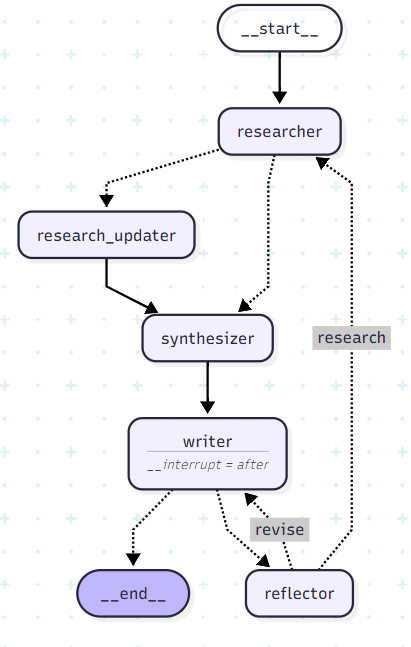

### Deconstructing Our Agent's Final Workflow: A Visual Guide

This diagram visualizes the sophisticated, multi-path workflow of our final "self-improving" agent. This is no longer a simple straight line; it's a dynamic graph with distinct loops for different tasks. Let's trace the paths the agent can take.

#### Path A: The Initial Draft

This is the path taken on the very first run, when the agent's `feedback_history` is empty.

1.  **`__start__ -> researcher`**: The process begins with initial research on the topic.
2.  **`researcher` -> `synthesizer`**: A **conditional edge** checks that there is no feedback history and correctly routes the flow to the `synthesizer` to process the new research.
3.  **`synthesizer` -> `writer`**: The key points are used to write the first draft.
4.  **`writer` (`__interrupt = after`)**: The graph pauses here. Thanks to our **checkpointer**, its entire state is saved, and it waits for our first round of feedback.

#### Path B: The Feedback Gateway & The "Brain"

Once we provide feedback, the agent resumes and enters its main reasoning loop.

1.  **`writer` -> `reflector`**: A "gatekeeper" edge checks that `feedback_history` now exists and sends the agent to its "brain," the `reflector` node. (If the user approves the script, our Python loop ends the process, and the graph correctly proceeds to `END` if it were to continue).
2.  **The Reflector's Decision**: The `reflector` analyzes our intent (is it a request for facts or a creative change?) and saves its decision (e.g., `"research"` or `"revise"`) into the agent's state.

#### Path C: The "Re-Research" Loop

This is the agent's smartest path, taken when it identifies a knowledge gap.

1.  **`reflector` -> `researcher`**: A conditional edge reads the `"research"` decision from the state and routes the agent back to the `researcher` to learn something new.
2.  **`researcher` -> `research_updater`**: The *same* conditional edge from step A2 now sees that `feedback_history` exists and correctly sends the flow to the `research_updater` to merge the new findings with the old.
3.  **`research_updater` -> `synthesizer`**: With its knowledge base expanded, the agent **must** re-synthesize its key points to form a new, more complete understanding.
4.  **`synthesizer` -> `writer`**: The agent now writes a new script based on this enriched understanding and pauses for our next round of feedback.

#### Path D: The "Simple Revision" Loop

This path is taken when the `reflector` decides no new research is needed. It is a highly efficient, direct loop.

1.  **`reflector` -> `writer`**: The conditional edge reads the `"revise"` decision from the state and sends the agent **directly back to the `writer` node.**
2.  **The `writer` Revises and Presents**: The `writer` node's internal logic detects that no new research was performed and executes its "refine" path. It incorporates the feedback into the script and, because it's the interrupt point, **immediately pauses** to present the new version, closing the feedback loop.

## Run the Agent Interactively

In [52]:
# This is our "user interface"
def get_human_feedback():
    """A simple function to get input from the command line."""
    print('\n\n')
    print('-'*50)
    feedback = input("Your feedback (or type 'approve' to finish): ")
    return feedback

### Breaking Down the Code Below

*   **`config = {"configurable": {"thread_id": "..."}}`**: This is the heart of persistence. The `thread_id` is like a unique file name for our conversation. Every time we call the agent with this same `thread_id`, LangGraph knows we are continuing the *same* conversation. This allows you to manage multiple, independent conversations at the same time.

*   **The Interactive Loop**: Our `while` loop follows a professional "invoke-get-update-resume" pattern:
    1.  **`app2.invoke(initial_input, config)`**: This kicks off the very first run for our `podcast_thread`.
    2.  **`app2.get_state(config)`**: After the agent pauses at an interrupt, we use this to load the latest saved snapshot of its memory for that `thread_id`.
    3.  **`app2.update_state(config, ...)`**: This is how we, the human, can **write directly into the agent's memory**. We take our `user_feedback` and inject it into the saved state, preparing the agent for its next step.
    4.  **`app2.invoke(None, config)`**: This is the **resume** command. By passing `None` as the input, we are telling LangGraph: "Don't start a new run. Wake up the agent from its last checkpoint and continue from where you left off."

In [53]:
# Define the config for checkpointing
config = {"configurable": {"thread_id": "podcast_thread"}}

# Initial input for the first run
initial_input = {
    "topic": "The surprising history of the Blackboard",
    "podcast_name": "Curious Chronicles",
    "feedback_history": []
}

# First run: Start the graph with initial input
print(f"First Run Config: {config}", flush=True)
print(f"Initial Input: {initial_input}", flush=True)
app2.invoke(initial_input, config=config)

# Loop for feedback and resumption
while True:
    # Get the current state after interrupt
    state_snapshot = app2.get_state(config)
    if not state_snapshot:
        raise ValueError("No state found after invoke. Check graph configuration.")
    final_state = state_snapshot.values
    print(f"Current State After Invoke: {final_state}", flush=True)

    print("\n--- 📜 AGENT'S SCRIPT ---", flush=True)
    print(final_state['script'], flush=True)

    user_feedback = get_human_feedback()

    if user_feedback.lower() == "approve":
        print("\n--- ✅ Script Approved. Final Version: ---", flush=True)
        print(final_state['script'], flush=True)
        break

    # Update feedback_history in the checkpointed state
    current_feedback = final_state.get("feedback_history", [])
    new_feedback_history = current_feedback + [user_feedback]
    print('\n\n')
    print(f"Updated Feedback History: {new_feedback_history}", flush=True)

    # Update the state with new feedback, preserving other fields
    app2.update_state(config, {"feedback_history": new_feedback_history})

    # Resume the graph from the interrupt
    print('\n\n')
    print(f"Resuming with Config: {config}", flush=True)
    app2.invoke(None, config=config)

First Run Config: {'configurable': {'thread_id': 'podcast_thread'}}
Initial Input: {'topic': 'The surprising history of the Blackboard', 'podcast_name': 'Curious Chronicles', 'feedback_history': []}


--- Starting initial research for: 'The surprising history of the Blackboard'---


---📝 Generating Initial Draft---
Current State After Invoke: {'topic': 'The surprising history of the Blackboard', 'podcast_name': 'Curious Chronicles', 'research_material': '# The History of the Classroom Blackboard James Pillans, headmaster and geography teacher at the Old High School in Edinburgh, Scotland, is credited with inventing the first modern blackboard when he hung a large piece of slate on the classroom wall. America’s fast-growing railroad system assured that by the middle of the 19th century, almost every classroom in America had a blackboard, mostly using slate shipped from quarries in Vermont, Maine, Pennsylvania, New York, Maryland and Virginia. Blackboard classroom history remained essent

### A Practical Example: Tracing Our Feedback Session

The agent's intelligence was demonstrated perfectly during our interactive session. Here's a breakdown of the feedback we provided and how the agent's workflow allowed it to respond correctly each time.

#### First Feedback: A Factual Request

*   **User's Action**: We provided the feedback: `"add some info about smart boards"`.
*   **Agent's Thought Process**: The graph resumed and moved to the `reflector` node. The `reflector` analyzed the feedback and correctly identified it as a request for new factual information that was not in the original research. It set its decision to `"research"`.
*   **Agent's Action**: The agent took **Path C (The "Re-Research" Loop)**.
    1. It went to the `researcher` to search for "smart boards."
    2. It updated its knowledge base in `research_updater`.
    3. It created new key points in `synthesizer`.
    4. It re-generated the script from scratch in `writer` using the new, enriched information, then paused for more feedback.

#### Second Feedback: A Creative Request

*   **User's Action**: We provided the feedback: `"Include that the podcast's topic for next week would be coffee beans"`.
*   **Agent's Thought Process**: The graph resumed and moved to the `reflector` node again. This time, it recognized the feedback as a stylistic/creative change—not a request for new facts. It correctly set its decision to `"revise"`. Crucially, it also **cleared the `new_research` field** in the state to signal that no new information was added.
*   **Agent's Action**: The agent took **Path D (The "Simple Revision" Loop)**.
    1. It moved directly from the `reflector` back to the `writer`.
    2. The `writer` node's internal logic saw that `new_research` was empty and executed its "refine" branch, skillfully weaving the mention of "coffee beans" into the existing script's conclusion.
    3. It then paused, presenting the final, polished script.

This session perfectly illustrates the power of our final graph architecture. The agent correctly distinguished between needing to learn and needing to edit, choosing the most efficient path every time to successfully incorporate all user feedback.

In [54]:
# The final State with all the fields
final_state

{'topic': 'The surprising history of the Blackboard',
 'podcast_name': 'Curious Chronicles',
 'research_material': '# The History of the Classroom Blackboard James Pillans, headmaster and geography teacher at the Old High School in Edinburgh, Scotland, is credited with inventing the first modern blackboard when he hung a large piece of slate on the classroom wall. America’s fast-growing railroad system assured that by the middle of the 19th century, almost every classroom in America had a blackboard, mostly using slate shipped from quarries in Vermont, Maine, Pennsylvania, New York, Maryland and Virginia. Blackboard classroom history remained essentially the same until the 1960s with schools teachers using slate blackboards like their predecessors. * C-SPAN Classroom is an Important Tool for Social Studies Teachers * How Can Teachers Cultivate Social Connection and Empathy in the Classroom?\n\n---\n\nWhen contractors began work on four classrooms of Emerson High School in Oklahoma, the

This final state provides a perfect snapshot of the agent's memory after completing its tasks. It clearly shows how the new findings from the research loop were successfully integrated into the research_material, and how subsequent fields like key_points and the final script were updated to reflect this new, comprehensive knowledge base.